## MSiA422  Project 1
##### Xiaoyun Gong, Yihan Zhou

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pymysql
%matplotlib inline
import seaborn as sns

## Part 1

In [17]:
## load namebystate
os.getcwd()
path = "/Users/shawngong/Desktop/namesbystate/" ### edit the path accordingly
os.chdir("/Users/shawngong/Desktop/namesbystate/")
doc = os.listdir()
#doc

In [18]:
class BabyNames():
    def __init__(self):
        self._read_txt()
        
    def _read_txt(self):
        newlist = []
        columns = ['state','sex','year','name','counts']
        for t in doc:
            if 'TXT' in t:  
                df = pd.read_csv(t,names=columns)
                newlist.append(df)
        self.df = pd.concat(newlist,ignore_index = True)
    
    def Count(self, state ="", year =""):
        df = self.df
        if state == "" and year == "":
            df = df
        elif state == "" and year != "":    
            df = df[df["year"] == year]
        elif state != "" and year == "":
            df = df[df["state"] == state]
        else:
            df = df[(df["state"] == state) & (df["year"] == year)]
        birth_count = df["counts"].sum()
        print("Total birth counts in "
                     + state + " and year "+ str(year) + " is " + str(birth_count))
        return birth_count 
    
    def Top10BabyNames(self, state = "IL", year = 2015):
        df = self.df
        if state == "" and year == "":
            df = df
        elif state == "" and year != "":    
            df = df[df.year == year]
        elif state != "" and year == "":
            df = df[df.state == state]
        else:
            df = df[(df.state == state) & (df.year == year)]
        df_agg = df.groupby(["sex",'name']).sum()[['counts']].reset_index()
        df_male = (df_agg[df_agg.sex == "M"].sort_values(by="counts",ascending=False))["name"].reset_index(drop=True)
        df_female = (df_agg[df_agg.sex == "F"].sort_values(by="counts",ascending=False))["name"].reset_index(drop=True)
        df_rank = pd.concat([df_male,df_female],ignore_index=True, axis=1).reset_index()
        df_rank.columns=["Rank","Male","Female"]
        return df_rank.iloc[0:10]
    
    def ChangeofPopularity(self, fromYear = 2014, toYear = 2015, top = 10):
        df = self.df
        df1 = df.groupby(['name','year']).sum()[['counts']].reset_index()
        df_from = df1[df1.year == fromYear]
        df_to = df1[df1.year == toYear]
        
        df_merge = pd.merge(df_from, df_to, how = "inner", on = "name")
        
        total_from = sum(df_from['counts'].values)
        total_to = sum(df_to['counts'].values)

        df_merge['prop_from'] = df_merge.counts_x / total_from
        df_merge['prop_to'] = df_merge.counts_y / total_to
        df_merge['change'] = df_merge.prop_to - df_merge.prop_from
        
        df_merged = df_merge.sort_values("change", ascending=True)
            
        df_increased = df_merged[df_merged.change >= 0.0001].sort_values(['change','prop_from'],ascending = [False,False])
        df_decreased = df_merged[df_merged.change <= -0.0001].sort_values(['change','prop_from'],ascending = [True,False])
        df_remained = df_merged[(df_merged.change >-0.0001) &(df_merged.change < 0.0001)].sort_values('prop_from',ascending = False)
        
        change_data = pd.DataFrame({'Rank':range(1,top+1)})
        change_data['Increased'] = df_increased.name.iloc[:top].reset_index(drop=True)
        change_data['Decreased'] = df_decreased.name.iloc[:top].reset_index(drop=True)
        change_data['Remained'] = df_remained.name.iloc[:top].reset_index(drop=True)
        
        return change_data
    
    def Top5NamesPerYear(self, year = 2015, sex =''):
        df = self.df
        if sex == "":
            df = df[df["year"] == year]
        else:
            df = df[(df["year"] == year) & (df["sex"] == sex)]
    
        df = df.groupby(["name","state"]).sum()[['counts']].reset_index()
        df = df.sort_values(["state","counts"], ascending = False)
        
    
        df_show = pd.DataFrame()
        df_show_list = []
        for st in df["state"].unique():
            state_array = list(df[df["state"]==st].iloc[0:5,[0,2]].values.flatten())
            state_array.insert(0,st)
            df_show_list.append(state_array)
        #create combined dataframe from 2D list of lists, each list element correspond to one state
        df_show = pd.DataFrame(data=df_show_list,columns=["State","Rank1","Num1","Rank2","Num2","Rank3","Num3","Rank4","Num4","Rank5","Num5"])
        
        return df_show.sort_values("State").reset_index(drop=True).head(2)
    
    def NamePopularityPlot(self, name = "Jim", yearRange=(2000,2015), state = "IL", sex = "M"):
        df = self.df
        dfnew = df[(df["year"] >= yearRange[0]) & (df["year"]<= yearRange[1])]
        dfnew1 = dfnew[df['state'] == "IL"]
        dfnew1 = dfnew1[df['sex'] == "M"]
        dfnew2 = dfnew1.groupby("year").sum()[['counts']].reset_index().rename(columns={"counts":"total_year_birth"})
        
        dfsub = df[(df["name"]=='Jim')& (df["state"]=='IL')& (df["year"]>=yearRange[0]) & (df["year"]<=yearRange[1])& (df["sex"]=='M')]
        dfmerged = pd.merge(dfsub,dfnew2,how="inner",on="year")
        dfmerged["popularity"] = dfmerged["counts"]/dfmerged["total_year_birth"]
        
        dfmerged.plot("year","popularity")
        plt.xlabel("year")
        plt.ylabel("popularity")
        plt.title("Popularity Plot" + " " + name)
    
    def NameFlip(self, n = 10):
        df = self.df
        table = df.pivot_table(values='counts', index=["name",'year'], columns=["sex"], aggfunc=sum)
        table["percentage_male"] = table["M"]/(table["M"] + table["F"])
        table["percentage_female"] = table["F"]/(table["M"] + table["F"])
        table =table[table['percentage_male'].notna()]
        name_dict = {}
        for name in table.reset_index()["name"].unique():
            name_table = table.loc[name,].reset_index()
            max_percentage = max(name_table["percentage_male"])
            min_percentage = min(name_table["percentage_male"])
            max_diff = max_percentage - min_percentage
            name_dict.update({name:max_diff})
        top_n = sorted(name_dict.items(), key=lambda x: x[1], reverse=True)[0:n]
        top_n_name = [x[0] for x in top_n]
        table = table.reset_index()
        new = table[table.name.isin(top_n_name)]
        for name in top_n_name:
            table_plot = new[new["name"] == name]
            table_plot.plot.line("year",["percentage_male","percentage_female"],title = "Percentage Share by Male and Female for Name: " + name)


In [19]:
### a. Constructor where you pass the file location to create Pandas
a = BabyNames()
df = a.df

In [20]:
### b. Count (state=’’, year=’’): returns the total number of births. A blank state or year should return all births of the empty input.
BabyNames.Count(a, state = "IL", year = 2000)

Total birth counts in IL and year 2000 is 151645


151645

In [21]:
###c. Top10BabyNames(state=’IL’, year=2015):
BabyNames.Top10BabyNames(a, state="IL", year=2015)

,Rank,Male,Female
0,0,Noah,Olivia
1,1,Liam,Emma
2,2,Alexander,Sophia
3,3,Jacob,Mia
4,4,Michael,Isabella
5,5,Benjamin,Ava
6,6,William,Sofia
7,7,Daniel,Abigail
8,8,Mason,Emily
9,9,James,Amelia


In [22]:
###d. ChangeOfPopularity (fromYear=2014, toYear=2015, top=10): 
BabyNames.ChangeofPopularity(a,fromYear=1997, toYear=2015, top=10)

,Rank,Increased,Decreased,Remained
0,1,Liam,Michael,Hunter
1,2,Ava,Nicholas,Natalie
2,3,Sophia,Tyler,Evan
3,4,Aiden,Brandon,Ian
4,5,Emma,Jessica,Blake
5,6,Isabella,Taylor,Caroline
6,7,Mia,Austin,Hailey
7,8,Mason,Christopher,Bryce
8,9,Jayden,Matthew,George
9,10,Oliver,Joshua,Jocelyn


In [23]:
###e. Top5NamesPerYear(year=2015,sex=’’):
BabyNames.Top5NamesPerYear(a, year = 2015, sex = 'F')

,State,Rank1,Num1,Rank2,Num2,Rank3,Num3,Rank4,Num4,Rank5,Num5
0,AK,Olivia,56,Emma,49,Aurora,46,Ava,41,Amelia,39
1,AL,Ava,298,Emma,287,Olivia,260,Harper,214,Elizabeth,187


<ipython-input-18-fdfc6343b401>:99: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfnew1 = dfnew[df['state'] == "IL"]
<ipython-input-18-fdfc6343b401>:100: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfnew1 = dfnew1[df['sex'] == "M"]


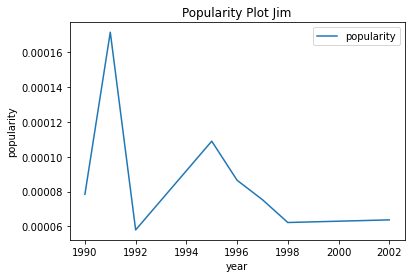

In [24]:
### f. NamePopularityPlot (name=’Jim’, yearRange=(2000,2015), state=’IL’,sex=’M’):
BabyNames.NamePopularityPlot(a,name = "Jim", yearRange=(1990,2015), state = "IL", sex = "M")

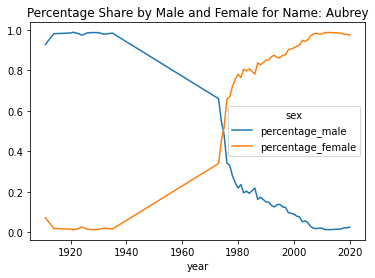

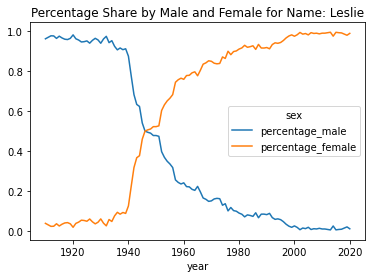

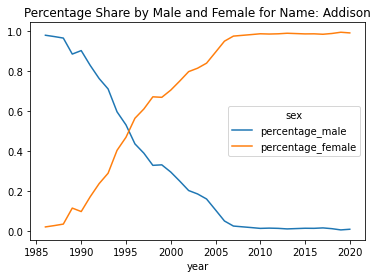

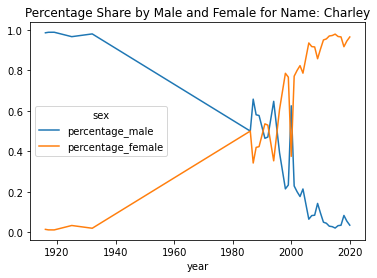

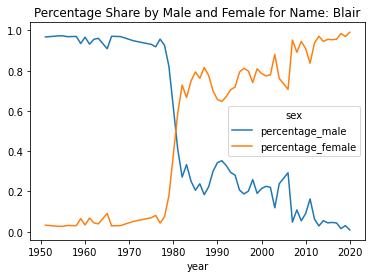

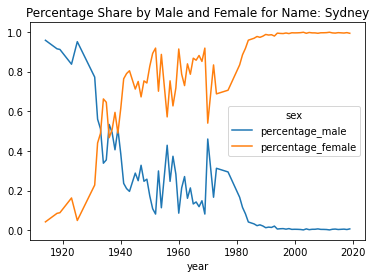

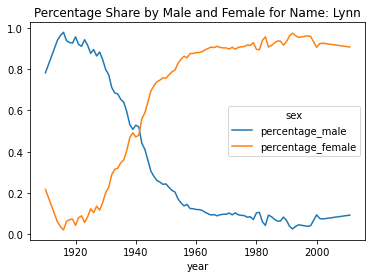

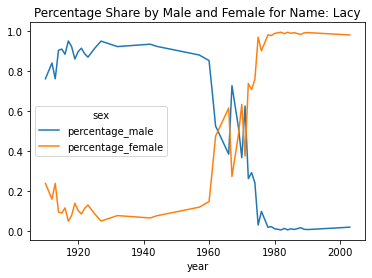

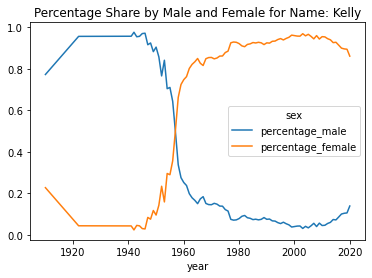

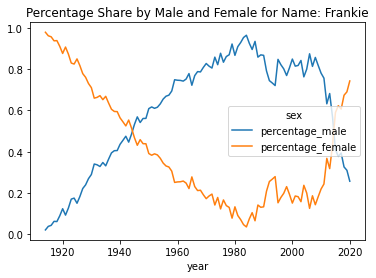

In [16]:
### g.NameFlip(n=10): List top n names that filliped over the years.
BabyNames.NameFlip(a, n = 10)

### Tell a story

In [9]:
name1 = df[(df["sex"]=="M") & (df["name"]=="Franklin")]
name1.head()

,state,sex,year,name,counts
80892,IN,M,1911,Franklin,10
81028,IN,M,1912,Franklin,25
81287,IN,M,1913,Franklin,25
81568,IN,M,1914,Franklin,25
81865,IN,M,1915,Franklin,40


In [10]:
group_state = name1.groupby("state").sum()['counts']
rank_name1 = group_state.sort_values(ascending = False)
top10_state = rank_name1.iloc[0:10,].reset_index()
top10_state

,state,counts
0,NY,8613
1,PA,8544
2,CA,7035
3,NC,6874
4,OH,6734
5,GA,6258
6,TX,6052
7,VA,5787
8,SC,4965
9,IL,4672


In [11]:
name1 = name1[name1.state.isin(top10_state.state)]
name1

,state,sex,year,name,counts
277625,IL,M,1910,Franklin,11
277850,IL,M,1911,Franklin,10
278096,IL,M,1912,Franklin,21
278479,IL,M,1913,Franklin,23
278889,IL,M,1914,Franklin,32
...,...,...,...,...,...
6135167,PA,M,2016,Franklin,15
6136389,PA,M,2017,Franklin,24
6137743,PA,M,2018,Franklin,29
6139151,PA,M,2019,Franklin,28


In [12]:
max(name1.counts)
name1[name1["counts"] ==322]

,state,sex,year,name,counts
6067507,PA,M,1933,Franklin,322


<AxesSubplot:xlabel='year', ylabel='counts'>

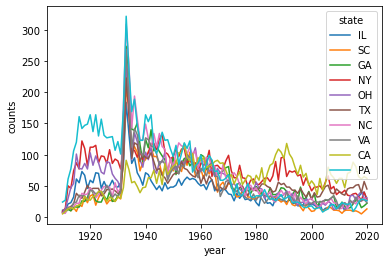

In [15]:
sns.lineplot(x="year", y="counts", data = name1, hue = "state", legend = "full")

##### Since my name is "Franklin", I am interested in the trend of babies named "Franklin" through those years.
##### Fistly, we can see the number of babies name "Franklin" has an increasing trend at the first 30 years of the 20th century. It is mainly because the president of the U.S is Franklin D Roosevelt at that time.
##### From the plot above, we can see that the name "Franklin" has been used the most in 1933 in PA, with the counts of 322.
##### Furthermore, we can see there is an obvious decreasing trend in naming newborns "Franklin" recently. It is mainly because other influential names appeared.

## Part 2

In [21]:
### set up connection
cnx = pymysql.connect(user = 'root', \
      password = '', \
      host = '127.0.0.1', \
      port = 3306, \
      db = 'world', \
      autocommit=True)

In [22]:
### load the data frames
df_country = pd.read_sql_query('select * from Country', con = cnx, index_col = 'Code')
df_city = pd.read_sql_query('select * from city', con = cnx, index_col = 'ID')
df_countrylanguage = pd.read_sql_query('select * from countrylanguage', con=cnx,index_col = ['CountryCode','Language'])

### 2.1 

This sql statement intended to select the top 10 most populous countries with population greater than 50,000,000, order them by the population (decreasingly), and display all the features of these countries included in the original table (Code, Name, Continent, Region, SurfaceArea, Independent year, Population, Life expectancy, GNP, GNP Old, Local Name, Government Form, Head of State, and Code2).

In [23]:
#df_country.head()

In [24]:
### use pandas
df1 = df_country[df_country.Population > 50000000].sort_values('Population', ascending=False).head(10).reset_index()
df1

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523.0,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947.0,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109.0,IN
2,USA,United States,North America,North America,9363520.0,1776.0,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813.0,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945.0,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939.0,ID
4,BRA,Brazil,South America,South America,8547403.0,1822.0,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211.0,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947.0,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831.0,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991.0,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580.0,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971.0,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150.0,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660.0,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960.0,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754.0,NG


In [25]:
### use sql
sql1 = """select *
from country
where population > 50000000
order by population DESC limit 10"""

sql_df1 = pd.read_sql_query(sql1, con = cnx)
sql_df1

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109,IN
2,USA,United States,North America,North America,9363520.0,1776,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939,ID
4,BRA,Brazil,South America,South America,8547403.0,1822,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754,NG


The outputs are the same. 

### 2.2

This SQL statement intented to select continents with population greater than 0, order the continents alphabetically by their names, and display the name, number of countries, and the population of each continent. 

In [26]:
### use pandas
df2 = df_country[df_country.Population > 0].groupby('Continent').agg(
    Number_Countries = pd.NamedAgg(column = 'Name', aggfunc = 'count'),
    Population = pd.NamedAgg(column = 'Population', aggfunc = 'sum')
).sort_values('Continent').reset_index()
df2

,Continent,Number_Countries,Population
0,Africa,57,784475000
1,Asia,51,3705025700
2,Europe,46,730074600
3,North America,37,482993000
4,Oceania,27,30401150
5,South America,14,345780000


In [27]:
### use sql
sql2 = """select Continent, count(*) As Number_Countries, sum(population) As Population
from country
where population > 0
group by Continent
order by cast(continent as char) ASC"""

sql_df2 = pd.read_sql_query(sql2, con = cnx)
sql_df2

,Continent,Number_Countries,Population
0,Africa,57,7.844750e+08
1,Asia,51,3.705026e+09
2,Europe,46,7.300746e+08
3,North America,37,4.829930e+08
4,Oceania,27,3.040115e+07
5,South America,14,3.457800e+08


The outputs are the same.

### 2.3

This sql statement intended to select the top 10 most populous cities in the USA, order them by the population of these cities (decreasingly), and display the name and population of each city. 

In [29]:
### use pandas
df3 = df_city.merge(df_country, left_on = 'CountryCode', right_on = 'Code', how = 'inner')
df3 = df3[df3.CountryCode == 'USA'][['Name_x', 'Population_x']].sort_values('Population_x', ascending = False).head(10).reset_index().rename(columns={'Name_x': 'Name', 'Population_x': 'population'}).drop(columns = 'index')
df3

,Name,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


In [28]:
### use sql
sql3 = """select city.Name As City, city.population
from city
inner join country ON city.CountryCode = country.code
where country.code = 'USA'
order by city.population DESC limit 10"""

sql_df3 = pd.read_sql_query(sql3, con = cnx)
sql_df3

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


The outputs are the same. 

### 2.4

This sql statement intended to select the 10 official languages with the greatest amount of people using it, order it by the popolation in the country that is using this language (decreasingly), and display the name of the country using this language, the language name, and the population in this country using this language.

In [31]:
df4 = df_countrylanguage.reset_index().merge(df_country, left_on = 'CountryCode', right_on = 'Code', how = 'inner')
df4['(Percentage * population) / 100'] = (df4.Percentage * df4.Population) / 100
df4 = df4[df4.IsOfficial == 'T'][['Name', 'Language', '(Percentage * population) / 100']].sort_values('(Percentage * population) / 100', ascending = False).head(10).reset_index().drop(columns = 'index')
df4

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


In [30]:
### use sql
sql4 = """select country.Name, Language, (Percentage * population) / 100
from countrylanguage
inner join country on countrylanguage.CountryCode = country.code
where IsOfficial = True
order by 3 DESC limit 10"""

sql_df4 = pd.read_sql_query(sql4, con = cnx)
sql_df4


,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


The outputs are the same. 

### 2.5

This SQL statement intended to get the five languages with the greatest number of people using, order them by the total number of people using it (decreasingly), and display the language name and the number of people using it. 

In [32]:
### use pandas
df5 = df_countrylanguage.reset_index().merge(df_country, left_on = 'CountryCode', right_on = 'Code', how = 'inner')
df5 = df5.groupby('Language').apply(lambda s: pd.Series({ 
    "sum((Percentage * population) / 100)": ((s["Percentage"]*s["Population"])/100).sum(), 
})).sort_values("sum((Percentage * population) / 100)", ascending = False).head(5).reset_index()
df5

,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


In [33]:
### use sql
sql5 = """select Language, sum((Percentage * population) / 100)
from countrylanguage
inner join country ON countrylanguage.CountryCode = country.code
group by Language
order by 2 desc limit 5"""

sql_df5 = pd.read_sql_query(sql5, con = cnx)
sql_df5


,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


The two outputs are the same.